In [1]:
import numpy as np
import matplotlib.pyplot as plt
from methods.helpers import random_matrix, random_vector, proj_pos_orthant
from methods.subgradient import Step

def f_i(x, i):
    min_obj = np.inf
    min_j = -1
    for j in range(N):
        obj_j = A[i, j]+x[j]*P[i, j]
        if min_obj > obj_j:
            min_obj = obj_j
            min_j = j
    return (min_obj - float(np.dot(T, x))/M, min_j)
    

def f(x):
    obj = 0
    for i in range(M):
        obj_i, _ = f_i(x, i)
        obj += obj_i
    return obj


def g_i(i, min_j):
    subgrad = []
    for j in range(N):
        if j == min_j:
            subgrad.append(P[i, j] - T[j]/M)
        else:
            subgrad.append(-T[j]/M)
    return np.array(subgrad)


N = 4
M = 100
t_bar = 0.5

A = random_matrix(M, N)
P = random_matrix(M, N)
T = []
# MAKES TIME VECTOR
for j in range(N):
    j_time = 0
    for i in range(M):
        j_time += P[i, j]
    T.append(t_bar*j_time/N)

T = np.array(T)



In [54]:
def constant_length(k):
    return 0.001

def constant_size(k, subgrad):
    return 0.01 / np.linalg.norm(subgrad)

def diminishing_step(k):
    return 0.001/(k+1)

def polyak_step_est(k, f_curr, f_best, subgrad):
    """ We want to maximize f. f_best + 0.001(k+1) simulates best objective"""
    return (f_best + 1/(k+1) - f_curr) / np.linalg.norm(subgrad)**2

def polyak_step(k, f_opt, f_best, subgrad):
    return (f_opt-f_best) / np.linalg.norm(subgrad)**2

1 2714.834376015626 [0.26969063 0.270875   0.17578375 0.2733875 ]
2 2886.940624140624 [0.41781562 0.36545833 0.28174208 0.4021375 ]
3 2972.0345200781235 [0.48390937 0.44664583 0.34671083 0.47895   ]
4 3023.9702013281226 [0.54338437 0.47359583 0.41048583 0.5236    ]
5 3059.1163552864577 [0.57728021 0.52222083 0.441465   0.56080833]
6 3080.081613470982 [0.60633378 0.55018512 0.46559    0.59455833]
7 3097.40368374628 [0.63213065 0.56515387 0.48669938 0.62408958]
8 3110.8212427740586 [0.65550565 0.57845942 0.50546326 0.64333958]
9 3122.7044128435004 [0.67654315 0.59043442 0.52235076 0.66066458]
10 3133.3527793207736 [0.69566815 0.60132079 0.53770304 0.67641458]
11 3142.387943175843 [0.7131994  0.61129995 0.55177595 0.69085208]
12 3150.1013965266557 [0.72961287 0.62051149 0.55976634 0.70417901]
13 3156.6971755445134 [0.74485394 0.62756506 0.5699717  0.71333972]
14 3162.8532359611804 [0.75907894 0.6341484  0.5794967  0.72188972]
15 3167.9461992562633 [0.77241488 0.64032027 0.58842638 0.72990

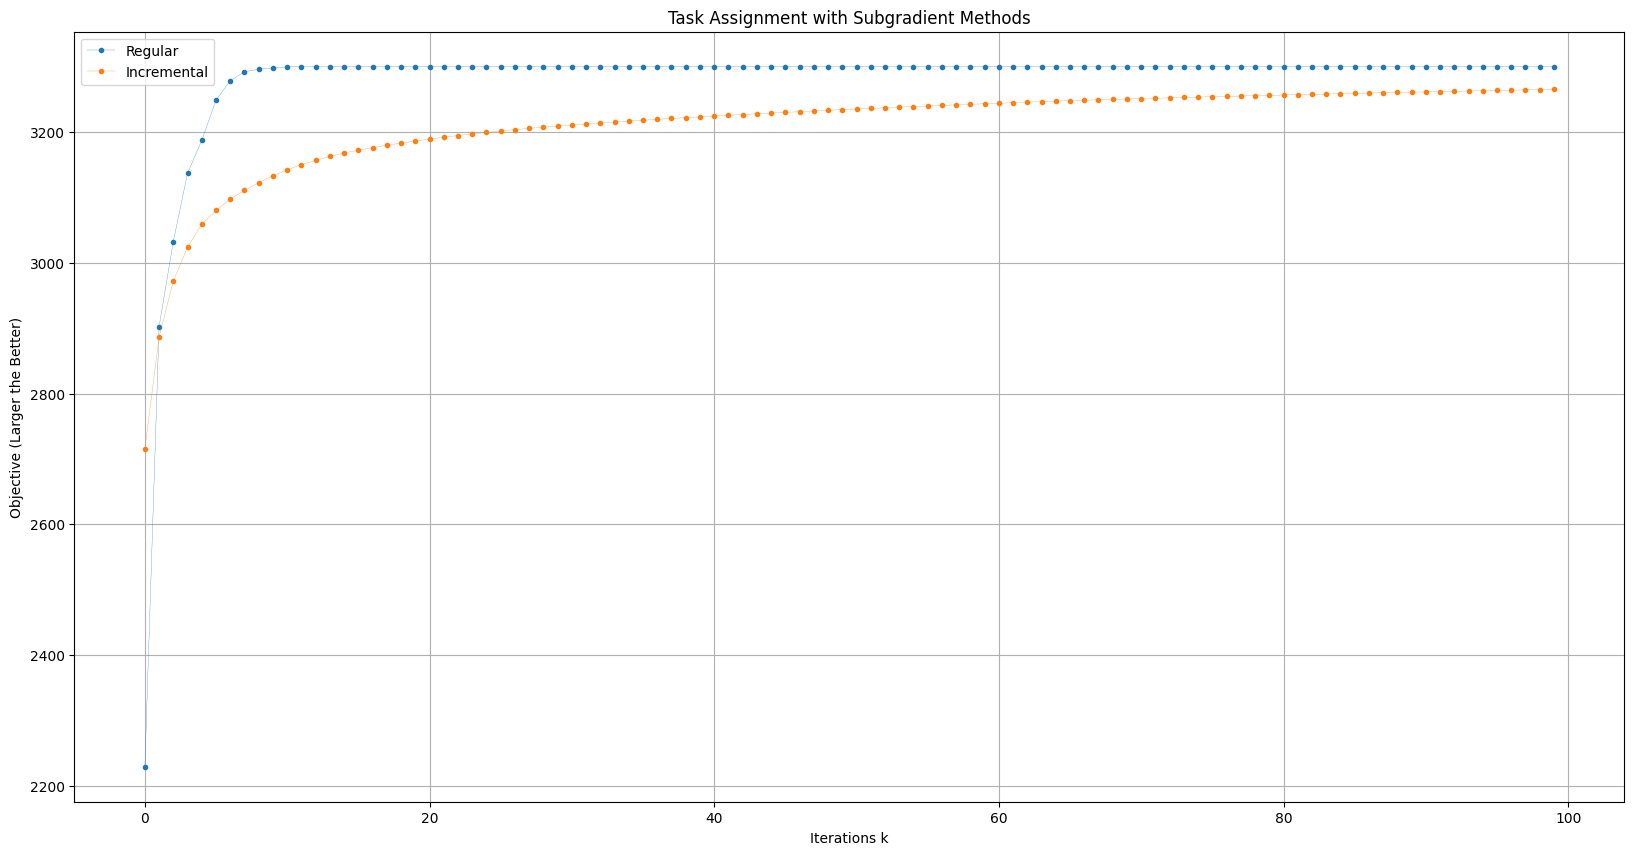

In [61]:

MAX_ITERATION = 100 # multiples of N
X0 = np.array([0,0,0,0])
S = MAX_ITERATION

def subgradient(step: Step, obj_optimal: float = None):
    iteration = 0
    x_curr = X0
    objectives_reg = []
    obj_best = f(x_curr)
    obj_prev = -np.inf
    x_best = X0
    s_counter = 0

    # REGULAR SUBGRADIENT
    for _ in range(MAX_ITERATION):
        # compute f 
        iteration += 1
        obj = 0
        subgradient = np.zeros(N)
        for i in range(M):
            obj_i, min_ij = f_i(x_curr, i)
            subgradient += g_i(i, min_ij)
            obj += obj_i

        # update best objective
        if (obj > obj_best):
            obj_best = obj
            x_best = x_curr
        
        # count if decreasing
        if (obj_prev > obj): 
            s_counter += 1
        else:
            s_counter = 0
        # if decreasing consecutively, reset
        if s_counter > S:
            x_curr = x_best
            s_counter = 0

        if step == Step.SQAURE_SUMMABLE_NON_SUMMABLE:
            x_curr = proj_pos_orthant(x_curr + diminishing_step(iteration)*subgradient)
        elif step == Step.CONSTANT_LENGTH:
            x_curr = proj_pos_orthant(x_curr + constant_length(iteration)*subgradient)
        elif step == Step.CONSTANT_SIZE:
            x_curr = proj_pos_orthant(x_curr + constant_size(iteration, subgradient)*subgradient)
        elif step == Step.POLYAK and obj_optimal is None: 
            x_curr = proj_pos_orthant(x_curr + polyak_step_est(iteration, obj, obj_best, subgradient)*subgradient)
        elif step == Step.POLYAK and obj_optimal is not None: 
            x_curr = proj_pos_orthant(x_curr + polyak_step(iteration, obj_optimal, obj_best, subgradient)*subgradient)
        else: 
            raise Exception("Step is not handled.")

        # if decreasing consecutively, reset
        if s_counter > S: 
            x_curr = x_best
            s_counter = 0
        
        # update prev objective
        objectives_reg.append(obj)
        obj_prev = obj

    return(objectives_reg)


def incremental_subgradient(step: Step, obj_optimal: float = None):
    iteration = 0
    x_curr = X0
    objectives_increment = []
    obj_best = f(x_curr)
    obj_prev = -np.inf
    x_best = X0
    s_counter = 0

    # INCREMENTAL SUBGRADIENT
    for _ in range(MAX_ITERATION):
        iteration += 1
        for i in range(M):
            _, min_ij = f_i(x_curr, i)
            subgradient = g_i(i, min_ij)

            obj = f(x_curr)
            # update best objective
            if (obj > obj_best): 
                obj_best = obj
                x_best = x_curr

            if step == Step.SQAURE_SUMMABLE_NON_SUMMABLE:
                x_curr = proj_pos_orthant(x_curr + diminishing_step(iteration)*subgradient)
            elif step == Step.CONSTANT_LENGTH:
                x_curr = proj_pos_orthant(x_curr + constant_length(iteration)*subgradient)
            elif step == Step.CONSTANT_SIZE:
                x_curr = proj_pos_orthant(x_curr + constant_size(iteration, subgradient)*subgradient)
            elif step == Step.POLYAK and obj_optimal is None: 
                x_curr = proj_pos_orthant(x_curr + polyak_step_est(iteration, obj, obj_best, subgradient)*subgradient)
            elif step == Step.POLYAK and obj_optimal is not None: 
                x_curr = proj_pos_orthant(x_curr + polyak_step(iteration, obj_optimal, obj_best, subgradient)*subgradient)
            else: 
                raise Exception("Step is not handled.")

        obj = f(x_curr)
        print(iteration, obj, x_curr)
        # update best objective
        if (obj > obj_best): 
            obj_best = obj
            x_best = x_curr

        # count if decreasing
        if (obj_prev > obj): 
            s_counter += 1
        else:
            s_counter = 0
        # if decreasing consecutively, reset
        if s_counter > S:
            x_curr = x_best
            s_counter = 0
        
        # update prev objective
        objectives_increment.append(obj)
        obj_prev = obj
    return(objectives_increment)


x = range(MAX_ITERATION)
y_reg = subgradient(Step.POLYAK, 3300)
y_increment = incremental_subgradient(Step.SQAURE_SUMMABLE_NON_SUMMABLE, 3294)
plt.figure(figsize=(20, 10))
plt.plot(x, y_reg, linewidth = 0.2, marker='.', label='Regular')
plt.plot(x, y_increment, linewidth = 0.2, marker='.', label='Incremental')
plt.grid()
plt.legend()
plt.xlabel("Iterations k")
plt.ylabel("Objective (Larger the Better)")
plt.title("Task Assignment with Subgradient Methods")
plt.savefig("CONSTANT_SIZE.png")

In [70]:
np.savetxt("A.txt", A)
B = np.loadtxt("A.txt", dtype="float")
print(np.array_equal(A, B))

[[98 60 92 91]
 [ 6 45 81 78]
 [36 62 76 50]
 [ 7  2 50 52]
 [92 41 23 92]
 [34  5 14 54]
 [38 97 75  0]
 [41 21 29 85]
 [42 81 43 85]
 [69 21 64  2]
 [19 69 28 45]
 [91 50 97  1]
 [40 13 57 26]
 [49 26 62 67]
 [12 45 54 54]
 [49 92 96 81]
 [30 68 61 77]
 [75 62 60 97]
 [18 68 57 92]
 [48 42 47 79]
 [22 74 75 45]
 [30 97 46  9]
 [ 6 27 12  5]
 [10 33 36 55]
 [46 37 87 33]
 [80 52 65 63]
 [91  7  0 80]
 [27 77 36 77]
 [79 14 71  6]
 [60 43 93 43]
 [98 73 91 89]
 [76 65 74 90]
 [54 74 10 32]
 [92 96 46  9]
 [43 39 87 20]
 [38 43 46 50]
 [76  6 83 51]
 [57 68 30 20]
 [93 58 86  8]
 [ 1 95 18  8]
 [45 24 82 40]
 [17 50 66 94]
 [85 82 98 49]
 [86 75 37 32]
 [28 27 64 97]
 [78 52 30 94]
 [23 32  1  8]
 [45 71 12 34]
 [28 55 26 45]
 [49 23 27 48]
 [43 56 76  8]
 [70 49 17  2]
 [26 39 19 56]
 [62 73 54 39]
 [26 96 34 61]
 [29 30 43 70]
 [40 10 35  3]
 [57 53 31 71]
 [28 93 84 24]
 [58 28  0 75]
 [ 4 27 20 18]
 [64 17 19 60]
 [38 25 44 52]
 [67 65 93 99]
 [ 1 65 36 62]
 [48 50 73 60]
 [54 50 98